[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/quickstarter_notebook.ipynb)

# ![title](https://cdn.discordapp.com/attachments/692035498625204245/1090596888857813062/banner.png)

## ADIALab forecasting competition. Tutorial notebook

The goal of this notebook is both to introduce the competitors to the exercise, as well as to suggest some directions that could be good starting points. Sugesstions here depicted are of course not a requirement and arbitrarily different directions can be pursued

### The cross-section forecast problem

The problem of directly predicting asset price returns is a fascinating albeit considerably hard problem in finance nowadays. For this reason, alternative prediction problems have surged in an attempt to circumvent these modelling difficulties, and still obtain predictions with tradeable potential. One of the most interesting alternatives is the problem of identifying the relative ordering in performance of an investment vehicle, in the cross-section of a pool or subset of them. This is the cross-section forecast problem. In this setting, we track a pool of investment vehicles that is generally obtained through some rule (for example S&P 500 tracks the performance of the 500 largest companies in the US) at different dates. This pool is typically known as the universe within the financial argot, and can be viewed as an object of study by itself. The challenge of this competition is to identify/sort/rank from best to worst, the performance of all elements of the universe at each given date. The signal for this problem is future performance remapped to the interval [-1,1], but our scoring function for the competition takes into account just the predicted vs true ranking of values, using Spearman's rank correlation.

To illustrate a bit further the interesting use cases of this problem, we can imagine a investment strategy that is long on the best performing element of the universe, and short in the worst. In this setting, no matter the direction of the market, is still possible to obtain positive returns (or to minimize losses).

The dataset presented to the competitors is an obfuscated version of high-quality market data. Therefore, details such as the nature of each investment vehicle, the frequency at which dates are measured (although it is given that it is constant interval) and the definition of each feature, are not available. We hope you enjoy the challenge!







### Data exporation

Let us now begin to understand our problem better by looking at the data. We only have access to a single table that constitutes our training and validation data. The true test data is hidden
and must be accessed through the custom API[[make url here]].


### Preliminary step

In [1]:
!pip3 install crunch-cli --upgrade

%env API_BASE_URL=http://api.adialab.staging.crunchdao.com
%env WEB_BASE_URL=https://adialab.staging.crunchdao.com/

import crunch
import sys

crunch = crunch.load_notebook(sys.modules[__name__])

Defaulting to user installation because normal site-packages is not writeable
env: API_BASE_URL=http://api.adialab.staging.crunchdao.com
env: WEB_BASE_URL=https://adialab.staging.crunchdao.com/
loaded inline runner with module: <module '__main__'>


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import requests
warnings.filterwarnings("ignore") # This is not advised in general, but it is used in this notebook to clean the presentation of results

In [9]:
# Getting the training data

current_crunch = requests.get("https://api.adialab.staging.crunchdao.com/v1/crunches/@current").json()
data_urls = requests.get(f"https://api.adialab.staging.crunchdao.com/v1/crunches/{current_crunch['number']}/data").json()

X_train = pd.read_parquet(data_urls['xTrain'], engine='pyarrow')
X_test = pd.read_parquet(data_urls['xTest'], engine='pyarrow')
y_train = pd.read_parquet(data_urls['yTrain'], engine='pyarrow')

In [10]:
X_train.head(10)

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,...,-0.731349,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,...,0.610428,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,...,0.212365,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,...,1.254787,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,...,-2.007721,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992
5,0,cd75786a46232a23b4e8f3e99b1045d0356426f88683e7...,0.397928,1.718154,0.970919,1.019976,-0.523070,1.000975,-1.350520,-0.095668,...,-0.714534,0.489504,-0.306691,2.064491,2.592456,0.888025,-1.512641,-1.164311,0.671042,-0.636903
6,0,9e194bf6a6663e2d71d120e7adcc7bb18416b8d43773ee...,0.926838,-1.608715,0.493489,-0.310964,-0.365767,-0.056785,0.248412,-0.005730,...,1.145286,-0.538777,0.455596,-0.845395,-2.115909,-0.164008,1.366854,0.020719,1.640821,1.623944
7,0,413eb24dbf37909b4023869809f4b0644bebfb376480b1...,-0.164051,1.711846,-0.000396,-0.074890,-0.515565,-0.162335,-0.317261,-0.068936,...,-1.154838,-1.438494,-0.277575,0.695643,0.506417,-0.304206,-0.306456,-0.810076,0.568860,0.568094
8,0,87ed8e2b2b32bf2ecddd0fbc723a186ba565dcf218a2fc...,-0.346972,-0.237940,-0.035638,-1.131278,-0.236790,0.141671,0.896292,-0.020427,...,-0.061339,-0.009924,-0.604464,0.237509,0.194966,0.923204,0.339524,-0.593550,-0.906084,0.195482
9,0,a6b69417add3ecfb23d061aca5b370e35de6802c90033f...,-0.554354,0.009493,-0.377920,0.054719,1.112429,-0.886331,-1.421340,-1.212338,...,1.247905,-0.156586,-0.016467,-0.764956,-1.974748,0.114405,-0.479952,-0.558842,-0.774358,-0.466825


In [11]:
X_train.tail(10)

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
492834,200,dbc8f0347aed8ab9c5024eed4dd9c1931db25262d1d228...,1.564755,-3.182815,-0.779034,-0.510961,1.306341,0.700877,-0.749824,-0.776366,...,0.802018,-0.526272,2.491148,-1.307958,0.276458,2.719896,-1.136485,2.894423,-0.620370,-1.075252
492835,200,3d5ca390733f9afcef8f535fb3f4d4ca3a1a83d4950c5d...,0.942778,0.656112,-1.271653,-1.118619,-1.216386,0.780052,1.389347,-0.968775,...,-0.322790,1.493182,1.930154,-1.637880,-0.520281,-1.808167,-0.826171,1.222137,-1.560762,-1.388304
492836,200,09aaf5e2121d3179416f4792c6588c7a3e1cd2f62b0eca...,-1.039734,1.321338,0.306758,0.297637,-1.068437,-0.353315,-0.149534,-0.357818,...,0.604842,-0.422287,0.234324,0.849246,-0.430537,-0.440274,0.744218,-0.961034,1.195188,-0.859837
492837,200,a665a5339b96fb027ce0636ca0203ad63b4ef9b1d37043...,0.010387,0.506554,-0.136663,1.358448,-1.464281,-0.397622,0.010991,-0.302175,...,-0.941897,-0.647187,0.513431,-0.289484,1.083617,0.069567,0.439262,-0.511713,1.507666,0.993017
492838,200,fe421ce0cb7c05e0f6e52b1e0f3af4a2538efcf60635f9...,-0.752089,1.291281,0.399747,-0.861134,1.618632,-0.344025,-1.358393,1.352904,...,0.211210,1.167530,-1.040283,0.295696,-0.173657,-0.339295,-0.924470,-0.535806,1.264995,-1.017879
492839,200,ebcc110654e89b43d198347ffdf95155a29dd820cba947...,0.745428,0.440497,-0.381767,1.300897,0.678993,-1.070824,-0.163306,0.051261,...,-0.479455,-1.193991,0.057748,-0.266845,-1.978869,0.173025,0.636986,-0.145487,-1.612342,0.670242
492840,200,ed93af2fb3db2b9150cd7896b2aed25973867f7b2ed9eb...,-0.961760,-0.365210,-2.539697,2.138631,0.538042,-0.479963,0.536242,-0.829076,...,-0.181034,-0.642921,1.288435,-0.998922,-0.983312,0.108591,-0.109811,0.109938,-1.127231,0.548930
492841,200,92d48ab6987d778ddc8b2eca74ff6a5c52d13afbf0e1ad...,-2.151686,2.589724,0.579317,-0.722497,-0.456387,-0.235593,-1.049381,0.218806,...,-0.037265,1.733668,0.443702,0.438292,0.559468,-1.700752,-2.230316,-0.355390,0.310145,-1.594635
492842,200,2cc2ea6e7ee8eaabe679620c414f07840c5e9226f28d0a...,-1.108856,0.340626,1.462280,0.606334,-0.547911,-0.259995,0.471951,1.366694,...,0.862505,0.735640,-1.822171,-0.510724,-2.559841,-0.556591,1.892561,1.818054,-0.408390,0.190328
492843,200,054ba9c0ace464311f89cbda16873a29566ff120e9c8bd...,-0.878197,-0.467488,1.553955,1.128971,1.562995,-1.405781,-1.011634,-1.937196,...,-0.821479,-0.165956,-0.031798,0.334694,-1.616378,-0.463422,1.549226,0.209962,0.020122,0.301778


All values other than those in **date** and **id** columns seem numerical, continuous and well-behaved, although we need more exploration to fully convince ourselves

In [12]:
X_train.shape

(492844, 463)

Dataset seems reasonably big, we will check its memory consumption, and if neccesary implement measures to address excess of memory usage

In [13]:
X_train.describe()

,date,0,1,2,3,4,5,6,7,8,...,451,452,453,454,455,456,457,458,459,460
count,492844.000000,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,...,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05,4.928440e+05
mean,120.892437,9.191454e-11,-4.644103e-11,-3.096069e-11,-6.966155e-11,4.257095e-11,1.044923e-10,8.707694e-11,7.740172e-12,-5.805129e-11,...,5.418120e-11,6.192138e-11,-6.966155e-11,-8.127180e-11,9.288206e-11,-9.675215e-11,-1.702838e-10,-7.740172e-11,-1.083624e-10,2.786462e-10
std,52.165445,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-5.933296e+00,-5.071468e+00,-4.221453e+00,-9.938923e+00,-6.866098e+00,-6.654506e+00,-8.959615e+00,-9.518451e+00,-7.745412e+00,...,-8.473229e+00,-4.633243e+00,-8.560513e+00,-4.718935e+00,-5.892952e+00,-4.417604e+00,-9.344660e+00,-5.903621e+00,-1.108917e+01,-7.698976e+00
25%,82.000000,-6.747223e-01,-6.547732e-01,-6.803612e-01,-5.875114e-01,-6.708213e-01,-6.521341e-01,-5.934361e-01,-6.618579e-01,-6.541740e-01,...,-6.575454e-01,-7.007750e-01,-6.621108e-01,-6.296892e-01,-6.817228e-01,-6.633840e-01,-6.668046e-01,-6.747046e-01,-6.703217e-01,-6.313479e-01
50%,130.000000,-2.692620e-02,-3.381254e-02,-2.156762e-02,2.938397e-02,-1.431236e-02,-3.979885e-03,3.982090e-02,1.215084e-02,-1.735724e-02,...,-5.577456e-04,-3.337362e-02,8.626801e-04,-5.825986e-03,1.236136e-02,-3.338462e-02,1.024020e-02,4.603543e-03,8.166757e-03,8.528246e-03
75%,162.000000,6.561302e-01,6.110490e-01,6.448868e-01,6.519764e-01,6.610781e-01,6.437386e-01,6.513834e-01,6.686709e-01,6.316506e-01,...,6.563277e-01,6.540017e-01,6.590208e-01,6.040753e-01,6.794928e-01,6.157853e-01,6.832675e-01,6.655305e-01,6.805757e-01,6.564940e-01
max,200.000000,5.421272e+00,7.005692e+00,7.850448e+00,4.292451e+00,9.759359e+00,5.435030e+00,4.168461e+00,5.217637e+00,1.240517e+01,...,9.845173e+00,9.887831e+00,5.139630e+00,8.936996e+00,6.631126e+00,8.872483e+00,4.661901e+00,6.826565e+00,5.674220e+00,4.717035e+00


In [14]:
X_train.nunique()

date       201
id      492844
0       490963
1       491016
2       490940
         ...  
456     490984
457     491002
458     491033
459     490945
460     491050
Length: 463, dtype: int64

The **id** column does not look informative if used as is in a prediction setting, since it has as many differentiated categorical values as the whole dataset. We will eliminate it in this notebook, in  later section.
**Date** column covers a relatively short number of points in time, 300 in our available data. Let us now check the distribution of datapoints across dates

In [15]:
max_date = np.max(X_train['date'])
max_feats = len(X_train.columns) 
print(max_date,max_feats)

200 463


In [16]:
X_train['date'].value_counts() 

150    4173
151    4113
153    4070
152    4036
154    4022
       ... 
8       880
5       878
0       808
1       796
2       782
Name: date, Length: 201, dtype: int64

<AxesSubplot: >

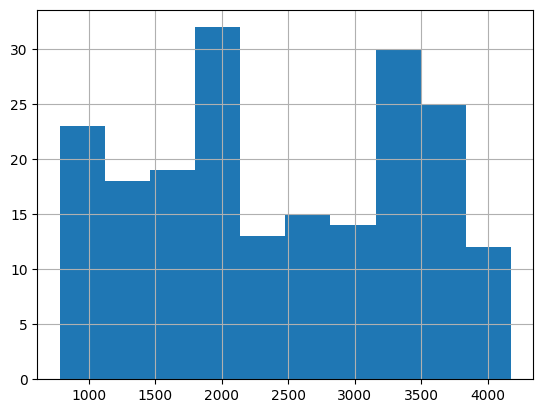

In [17]:
X_train['date'].value_counts().hist()

Which seems enough well-behaved for our purposes

In [18]:
y_train.nunique()

date       201
id      492844
y       379337
dtype: int64

In [19]:
y_train.head(10)

,date,id,y
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,0.192308
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.476959
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.080645
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,0.953125
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,-0.979263
5,0,cd75786a46232a23b4e8f3e99b1045d0356426f88683e7...,-0.170330
6,0,9e194bf6a6663e2d71d120e7adcc7bb18416b8d43773ee...,0.578125
7,0,413eb24dbf37909b4023869809f4b0644bebfb376480b1...,0.850230
8,0,87ed8e2b2b32bf2ecddd0fbc723a186ba565dcf218a2fc...,-0.619816
9,0,a6b69417add3ecfb23d061aca5b370e35de6802c90033f...,0.698157


The target variable **y** seems coherent with the problem description, we can investigate it a bit further later on

Let us check the null value distribution

In [20]:
np.sum(np.sum((X_train.isna()))) 

0

No missing values to worry about!

We should now plot some of the features and observe them under different smoothing values. We do this in order to visually uncover dominant trends that otherwise may be obscured by noise or high volatility. Notice that by plotting features directly we are not accounting for the dates separation of values. This however still lets us understand global information about the universe. Namely, if features exhibit clear trends, then we may be able to interpret that effect as "universe drift". If universe drift is present, it could be an interesting effect to harness in our predictions

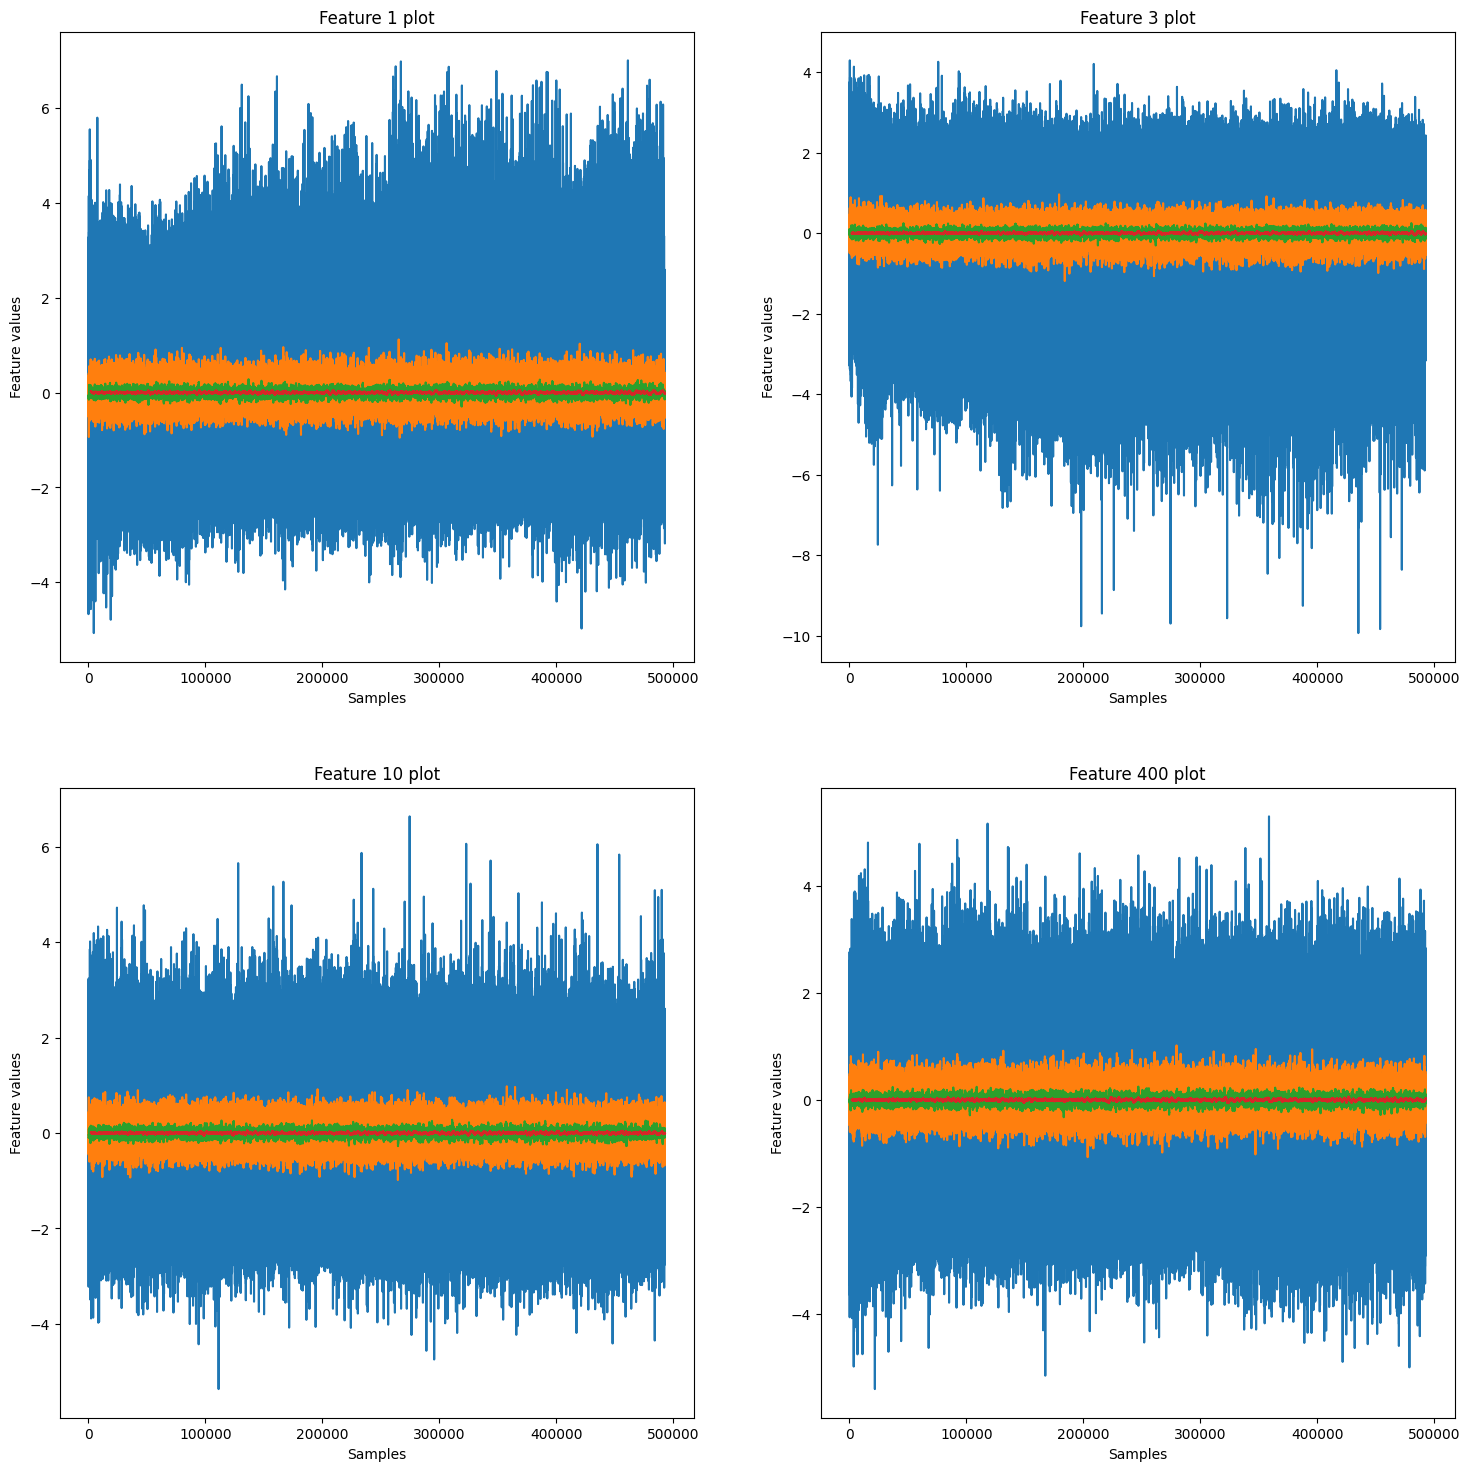

In [21]:
fig, axs = plt.subplots(2, 2,figsize=(18,18))
feats = ['1','3','10','400']
ax = axs.flatten()

for idx,a in enumerate(ax):
    a.plot(X_train[feats[idx]])
    a.plot(X_train[feats[idx]].rolling(20).mean())
    a.plot(X_train[feats[idx]].rolling(200).mean())
    a.plot(X_train[feats[idx]].rolling(2000).mean())
    a.set_title('Feature ' +  feats[idx] + ' plot')
    a.set(xlabel='Samples', ylabel='Feature values')
    

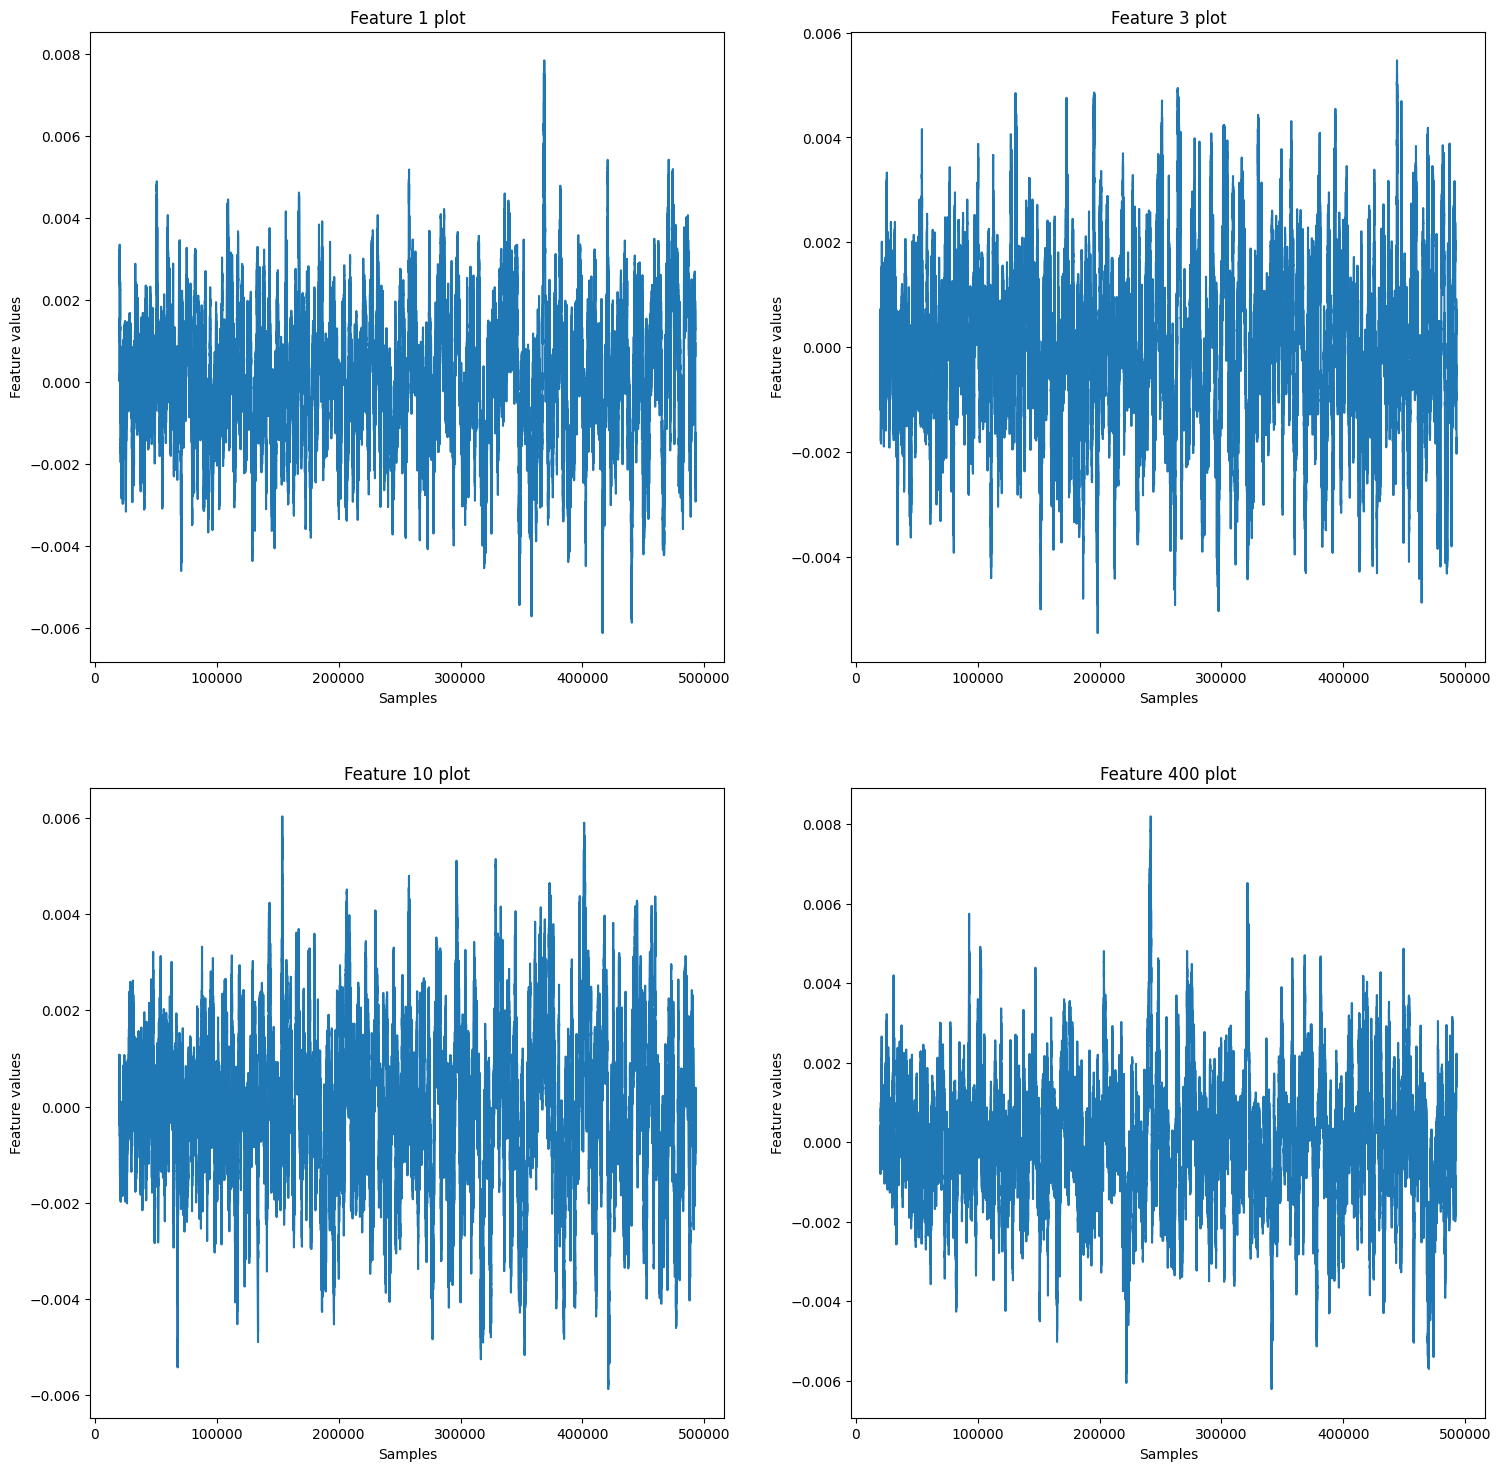

In [22]:
fig, axs = plt.subplots(2, 2,figsize=(18,18))
ax = axs.flatten()
for idx,a in enumerate(ax):
    a.plot(X_train[feats[idx]].rolling(20000).mean())
    a.set(xlabel='Samples', ylabel='Feature values')
    a.set_title('Feature ' +  feats[idx] + ' plot')

Let us now look at it in a per-date basis

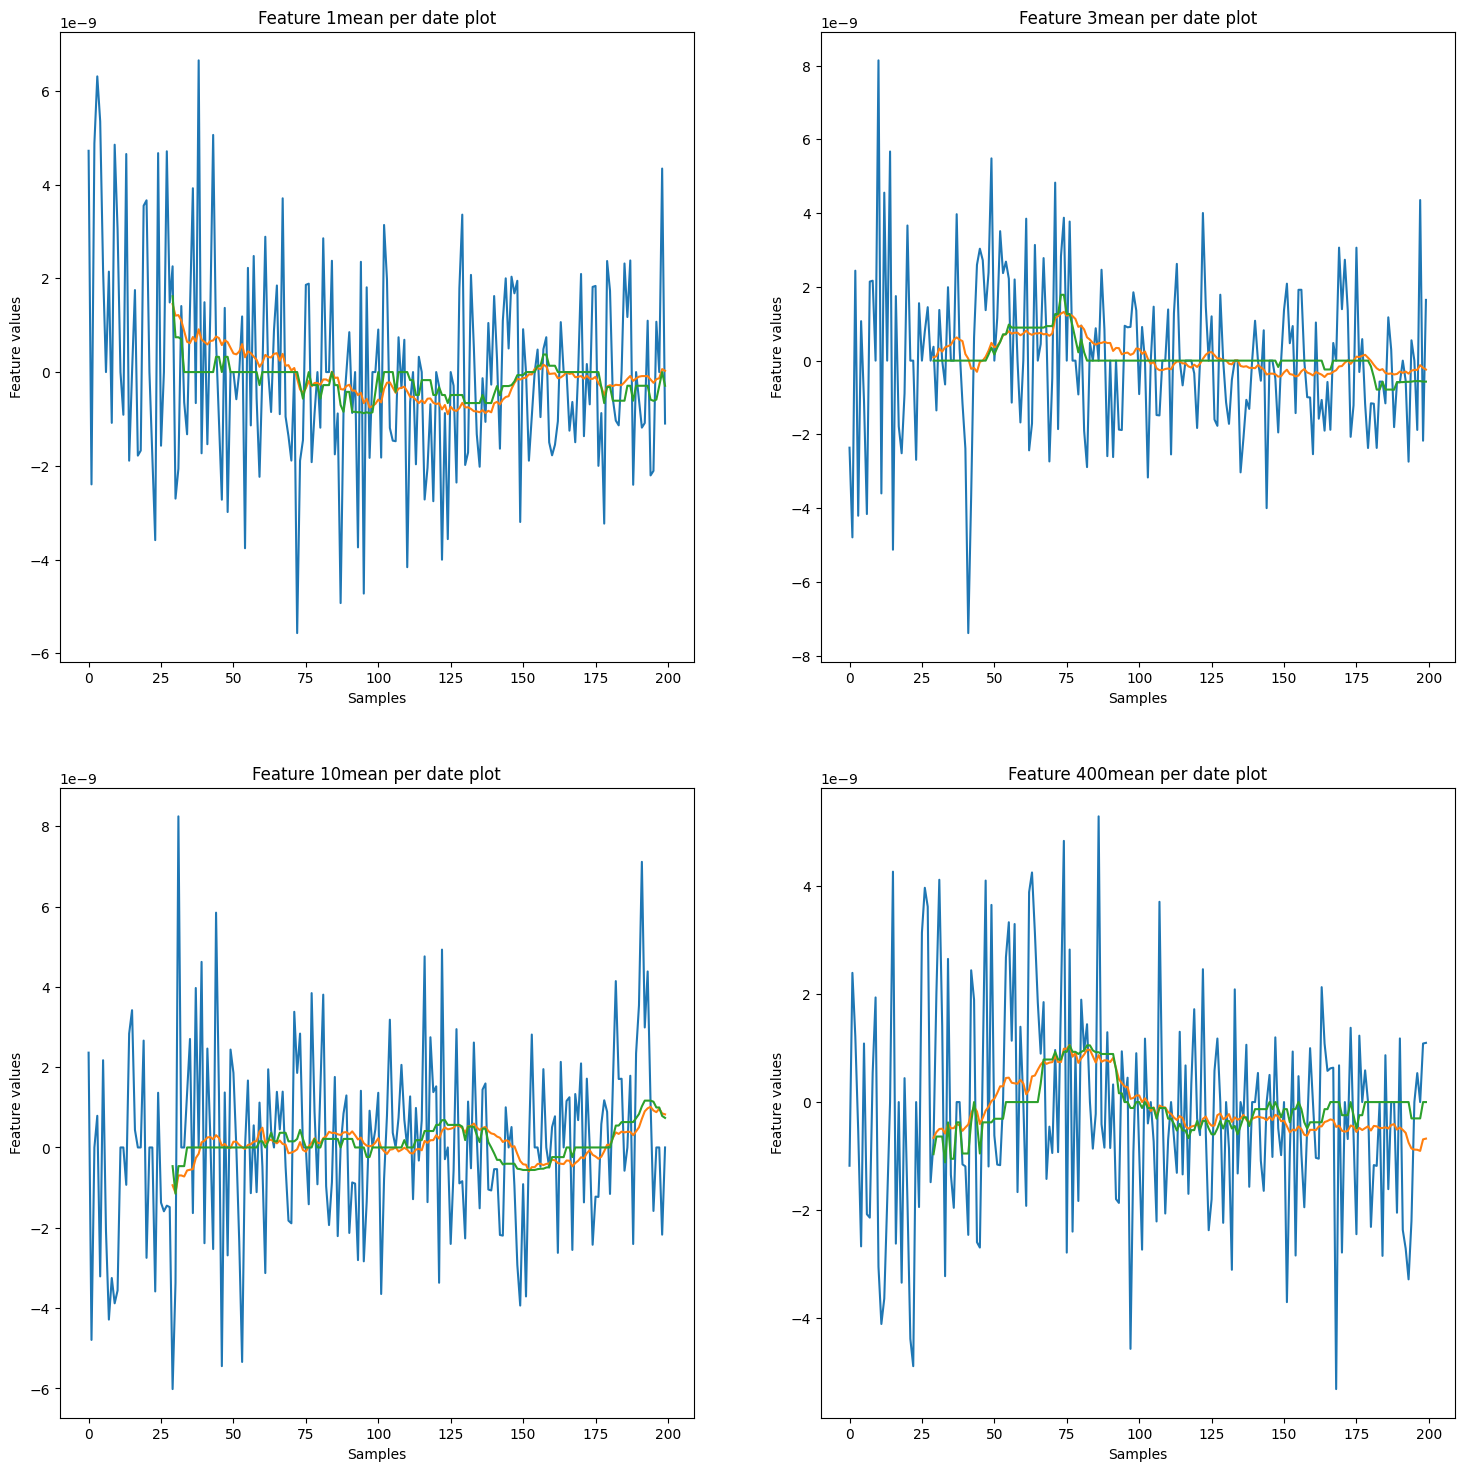

In [23]:
x_means_1, x_means_3,x_means_10,x_means_700 = [],[],[],[]
x_means = [x_means_1, x_means_3,x_means_10,x_means_700]

for i in range(max_date):
    x_means_1.append(X_train.loc[X_train['date']==i,'1'].mean())
    x_means_3.append(X_train.loc[X_train['date']==i,'3'].mean())
    x_means_10.append(X_train.loc[X_train['date']==i,'10'].mean())
    x_means_700.append(X_train.loc[X_train['date']==i,'400'].mean())

fig, axs = plt.subplots(2, 2,figsize=(18,18))
ax = axs.flatten()
for idx,a in enumerate(ax):
    a.plot(x_means[idx])
    a.plot(pd.DataFrame(x_means[idx]).rolling(30).mean())
    a.plot(pd.DataFrame(x_means[idx]).rolling(30).median())
    a.set(xlabel='Samples', ylabel='Feature values')
    a.set_title('Feature ' +  feats[idx] + 'mean per date plot')

Features do not exihibit clear trending behaviours. Let us now try to understand how features relate to each other 

In [24]:
import seaborn as sns

In [25]:
gcorr = np.corrcoef(X_train.iloc[:,2:],rowvar=False) #numpy is much faster that pandas corr() method for large only-numerical data without missing values.

In [26]:
def plot_correlation_heatmap(corr):
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

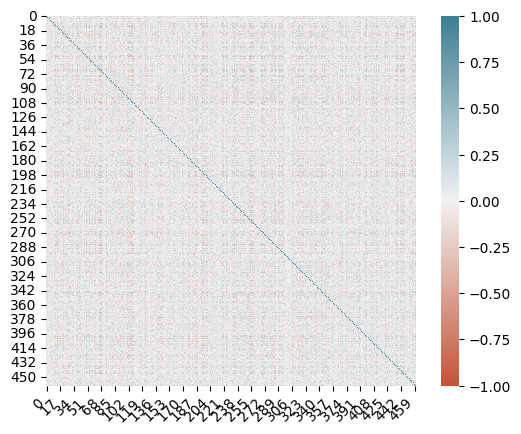

In [27]:
plot_correlation_heatmap(gcorr)

Clearly this is manually untractable, but we will still like to explore at least certain subsets of the variables to try to obtain a representative picture of the situation

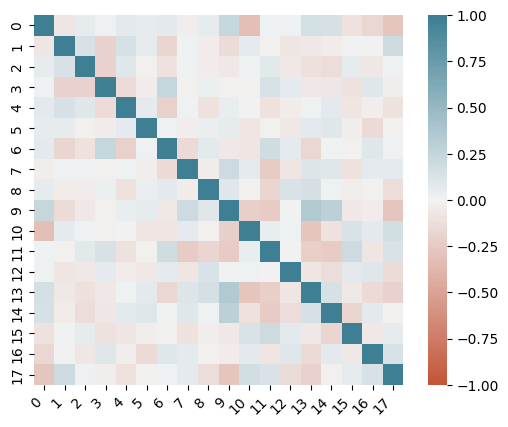

In [28]:
corr = np.corrcoef(X_train.iloc[:,2:20],rowvar=False)
plot_correlation_heatmap(corr)

Very low correlations in the first variabes, let us consider other cases

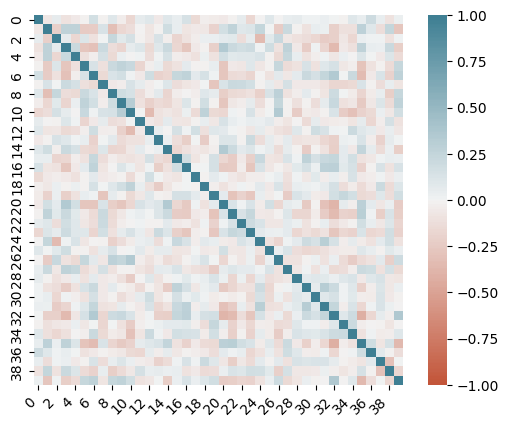

In [29]:
corr = np.corrcoef(X_train.iloc[:,20:60],rowvar=False)
plot_correlation_heatmap(corr)

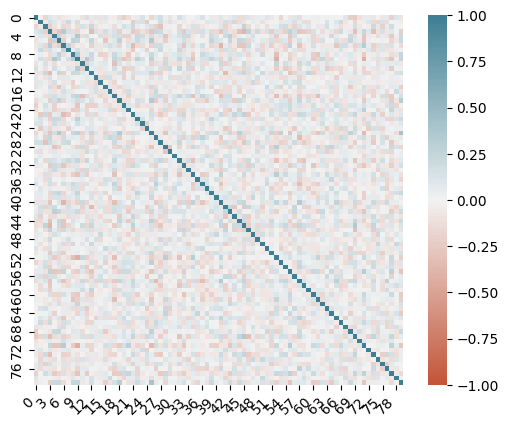

In [30]:
corr = np.corrcoef(X_train.iloc[:,100:180],rowvar=False)
plot_correlation_heatmap(corr)

Rather than continue with visual inspection, let us resort to numerical exploration. For example, let us see whats the strongest case of negative correlation available

In [31]:
corr = np.corrcoef(X_train.iloc[:,2:],rowvar=False)
np.min(corr)

-0.5148075067211341

Let us now see the strongest case of positive correlation, for this we need to look at values that are not corr(X,X) and thus value 1. Checking the ranking of correlations already reveals the
maximum value we are looking for

In [32]:
cs= np.sort(corr.flatten())
cs[-466:-452]

array([0.51947575, 0.52355625, 0.52355625, 0.55104344, 0.55104344,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

Where it shows maximum value of 0.5301, which can be deduced to correspond to the first non trivial correlation comparison between variables (first disctinct variables case). Let us check the values in a histogram

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

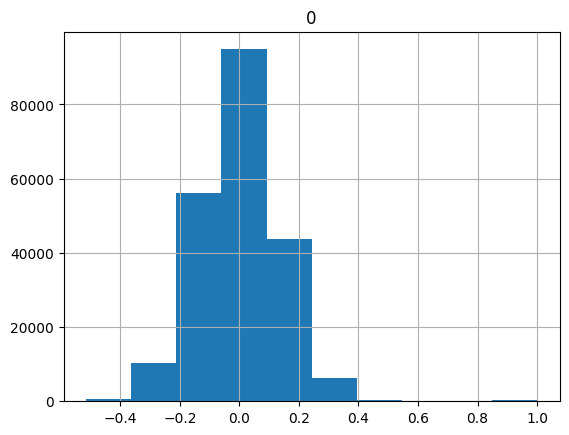

In [33]:
pd.DataFrame(gcorr.flatten()).hist()

Overall, there is a consistent tendecy to show low to at most medium correlation levels in all observed cases. This could ease our concerns about negative properties, such as multicolinearity,
dampening the performance of some of our model choices. Let us now consider the frequency by which values or ranges of values occur in each feature

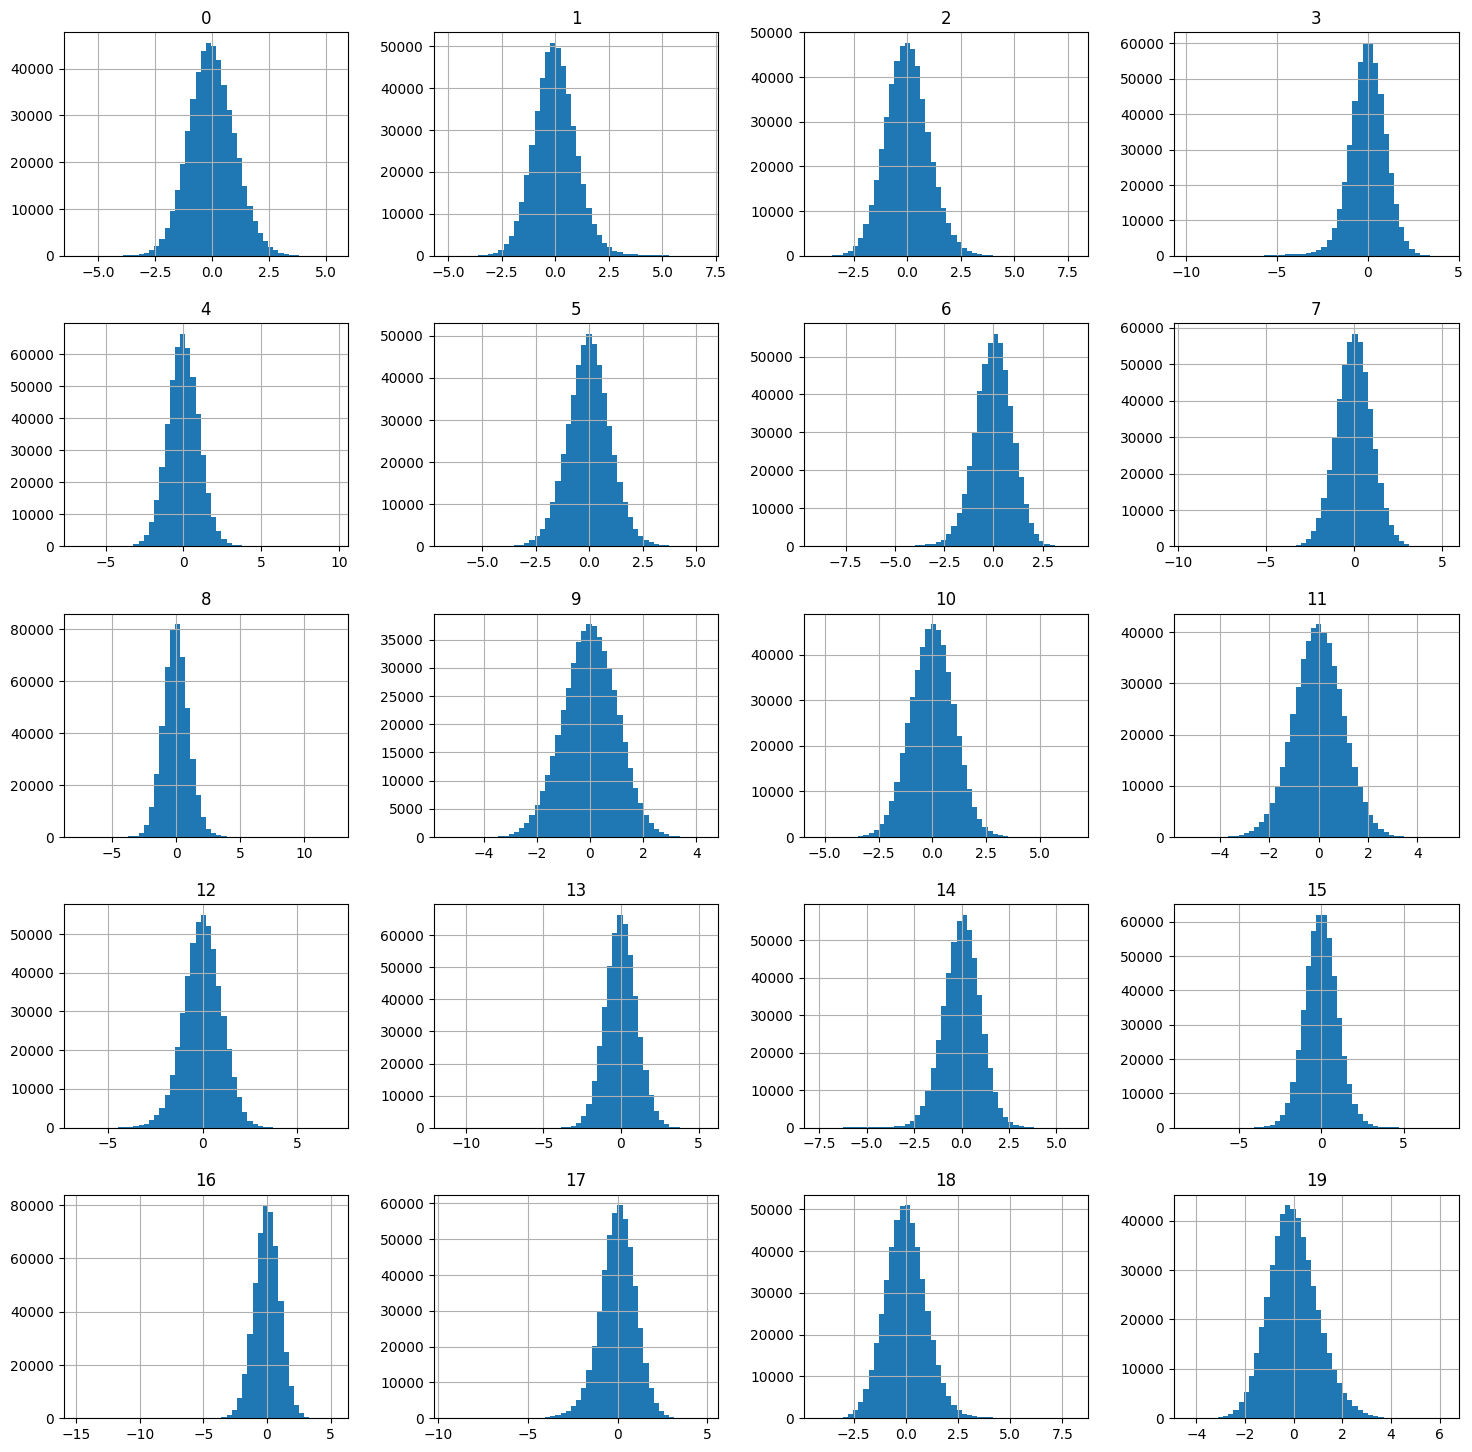

In [34]:

X_train.iloc[:,2:22].hist(bins=50,figsize=(18, 18))
plt.show()

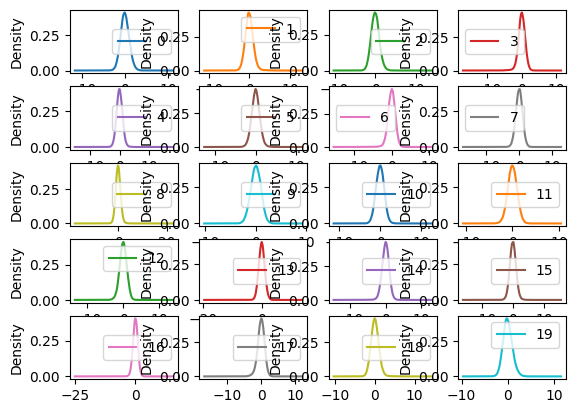

In [35]:
X_train.iloc[:,2:22].plot(kind='density', subplots=True, layout=(5,4), sharex=False)
plt.show()

Visuallization by means of histograms, sheds light as to where observations really concentrate in the range of normalized values, the first batch of features looked very clear in this regard, let us continue inspecting a bit longer

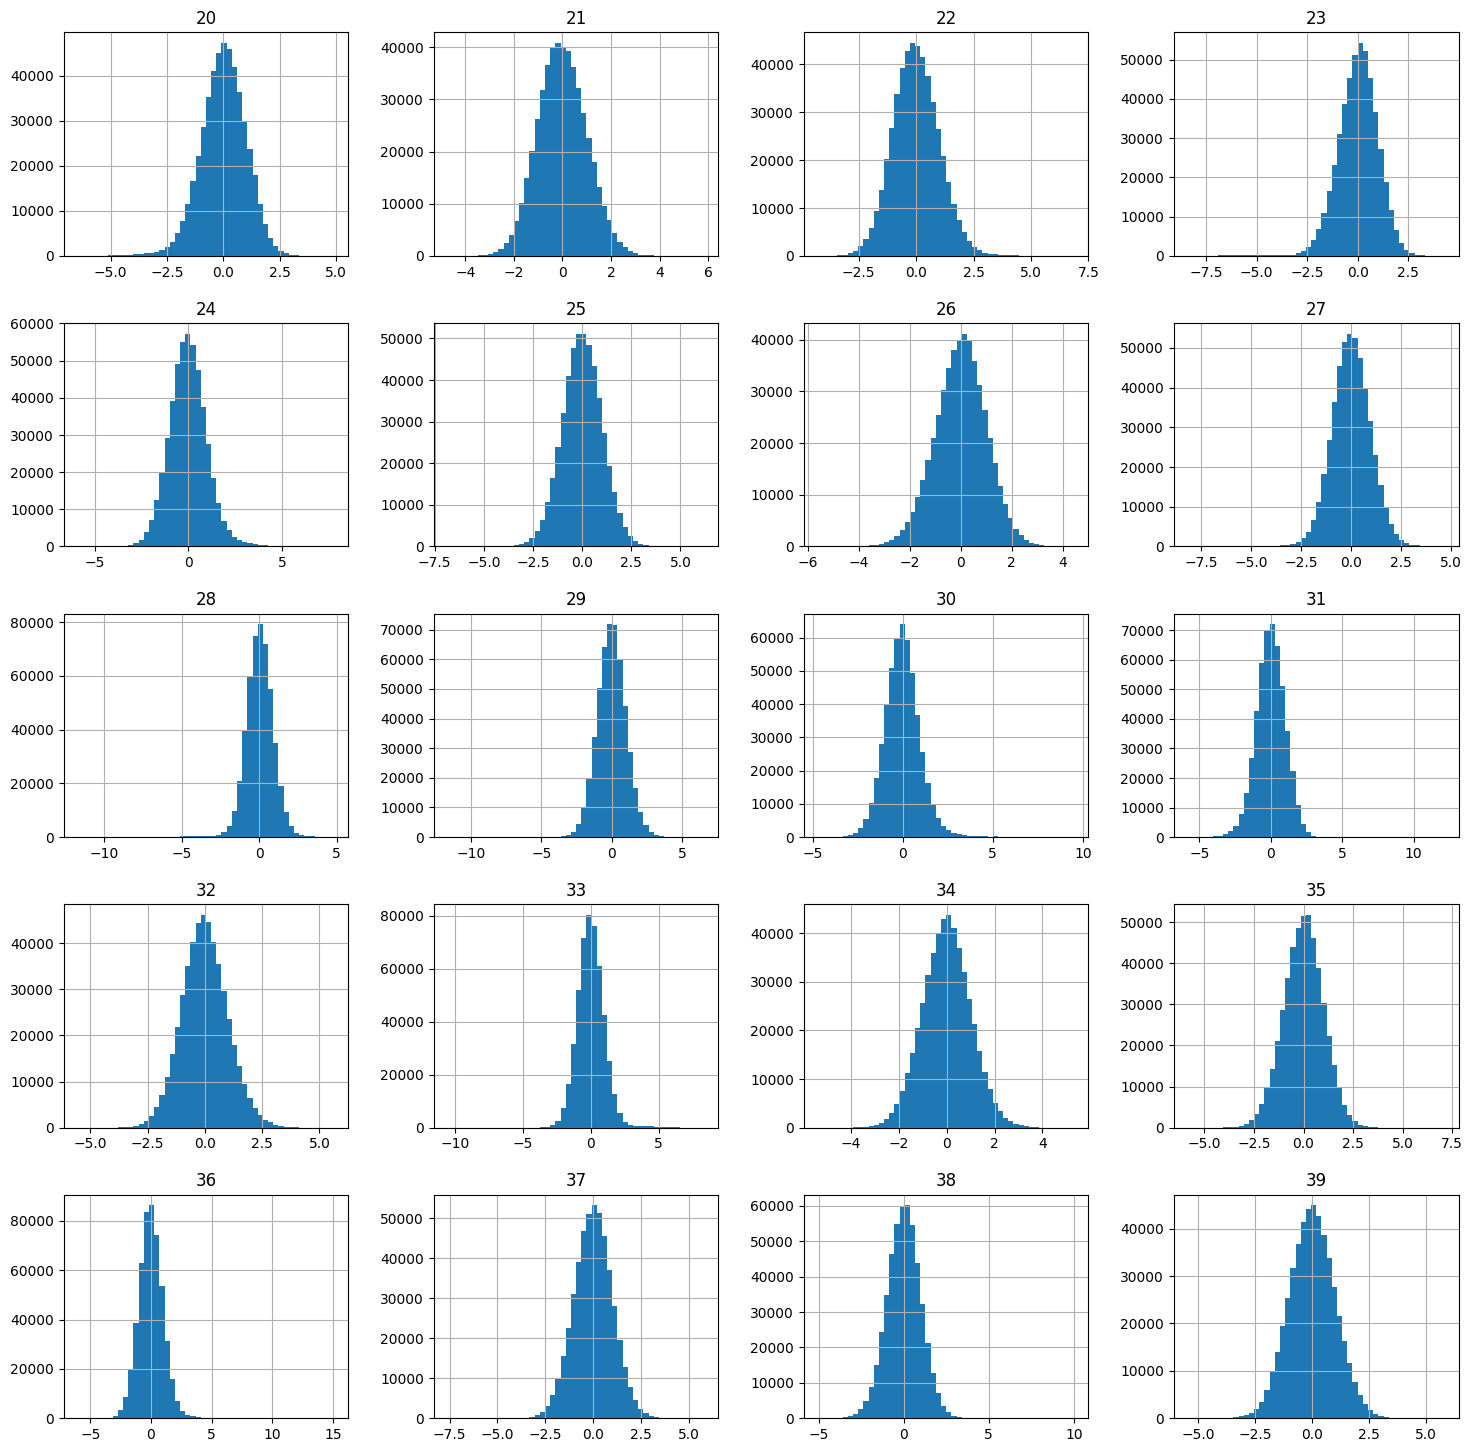

In [36]:

X_train.iloc[:,22:42].hist(bins=50,figsize=(18, 18))
plt.show()

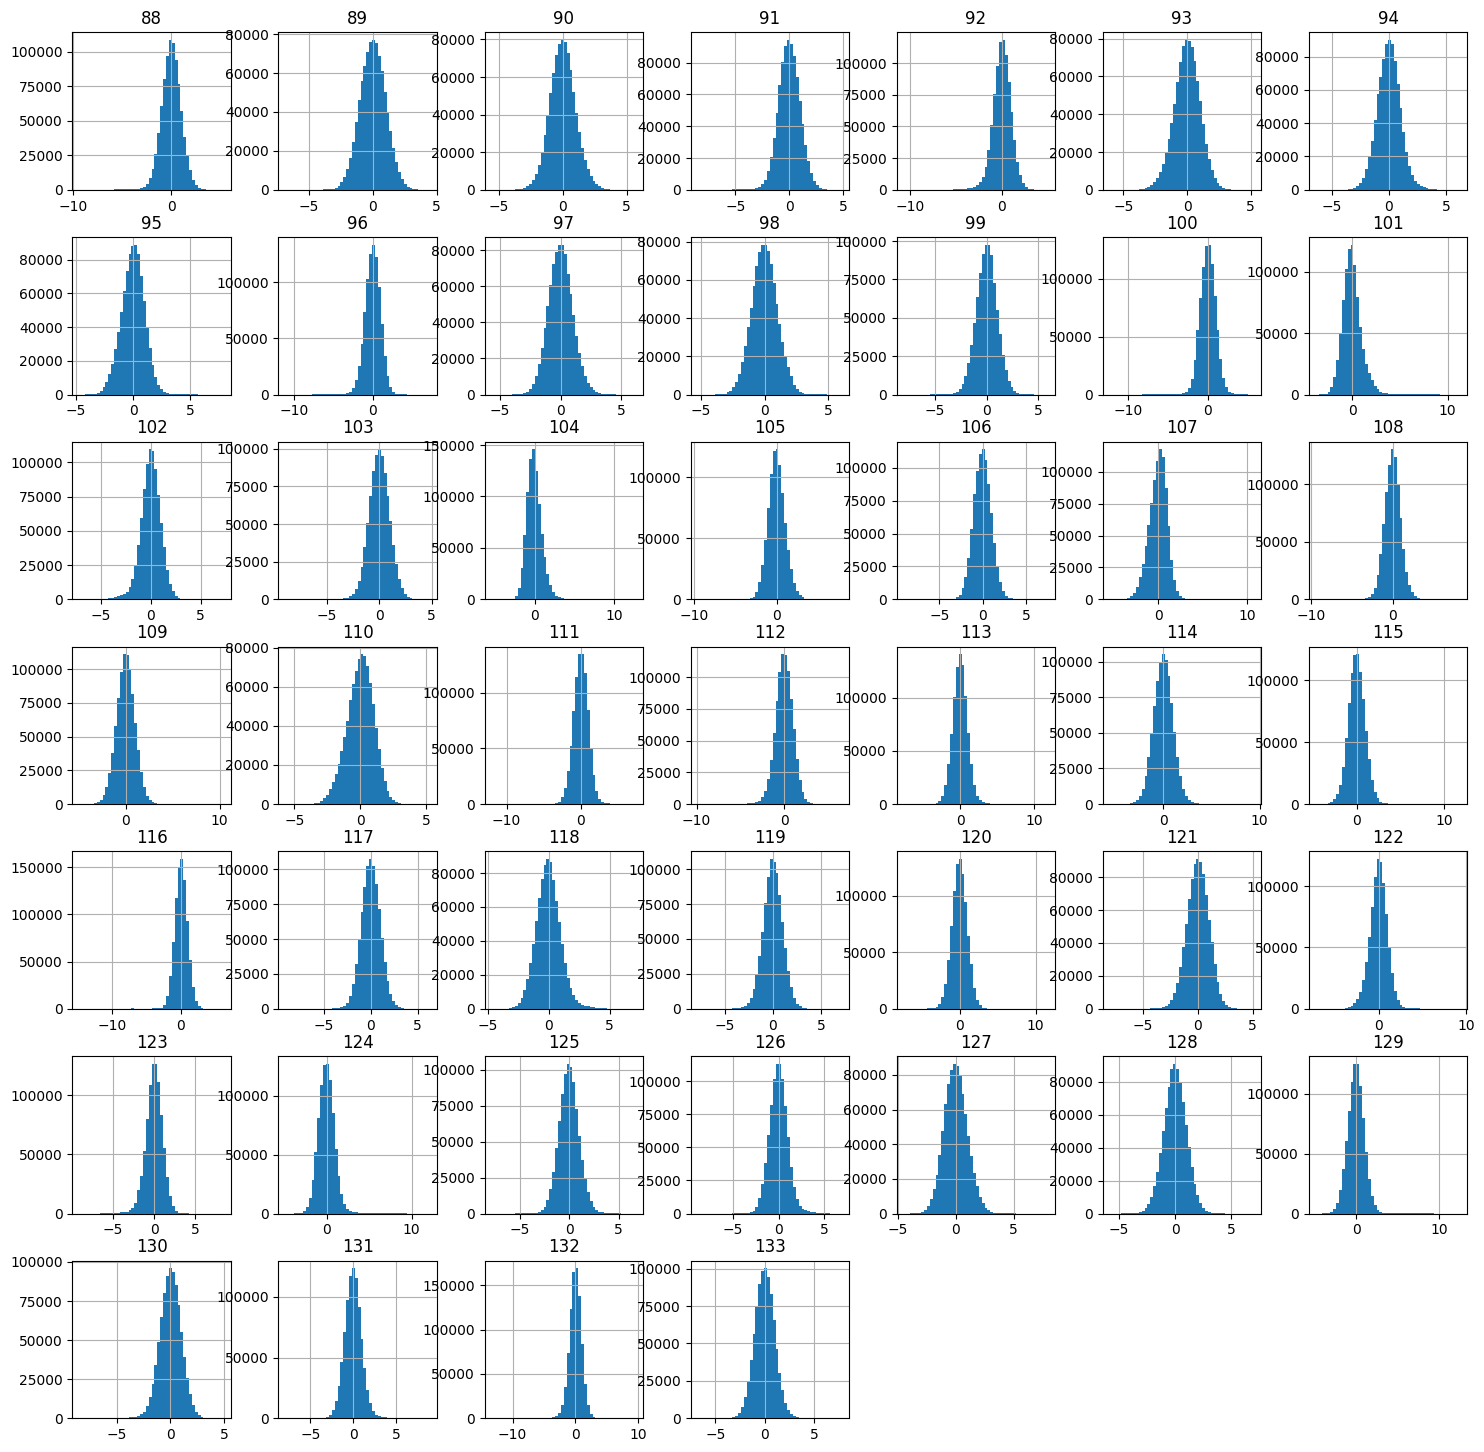

In [35]:
X_train.iloc[:,90:136].hist(bins=50,figsize=(18, 18))
plt.show()

Features are markedly unimodal, we will test if they conform to normal distributions shortly

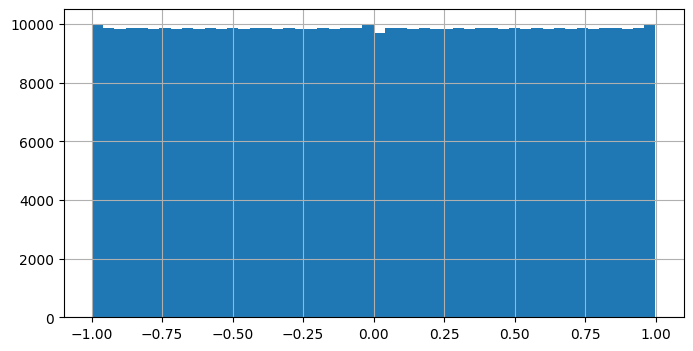

In [37]:
y_train.y.hist(bins=50,figsize=(8, 4))
plt.show()

The target variable, on the other hand, seems uniformly distributed. Let us proceed with the gaussianity tests

In [39]:
!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 105.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 45.2 MB/s eta 0:00:00


In [40]:
from statsmodels.graphics.gofplots import qqplot

The qqplot allows one to visually assess the degree of gaussianity of a feature, by noticing how well the samples of the feature of analysis fit to the red line in the plot. Better fit implies closer to a pure gaussian distribution

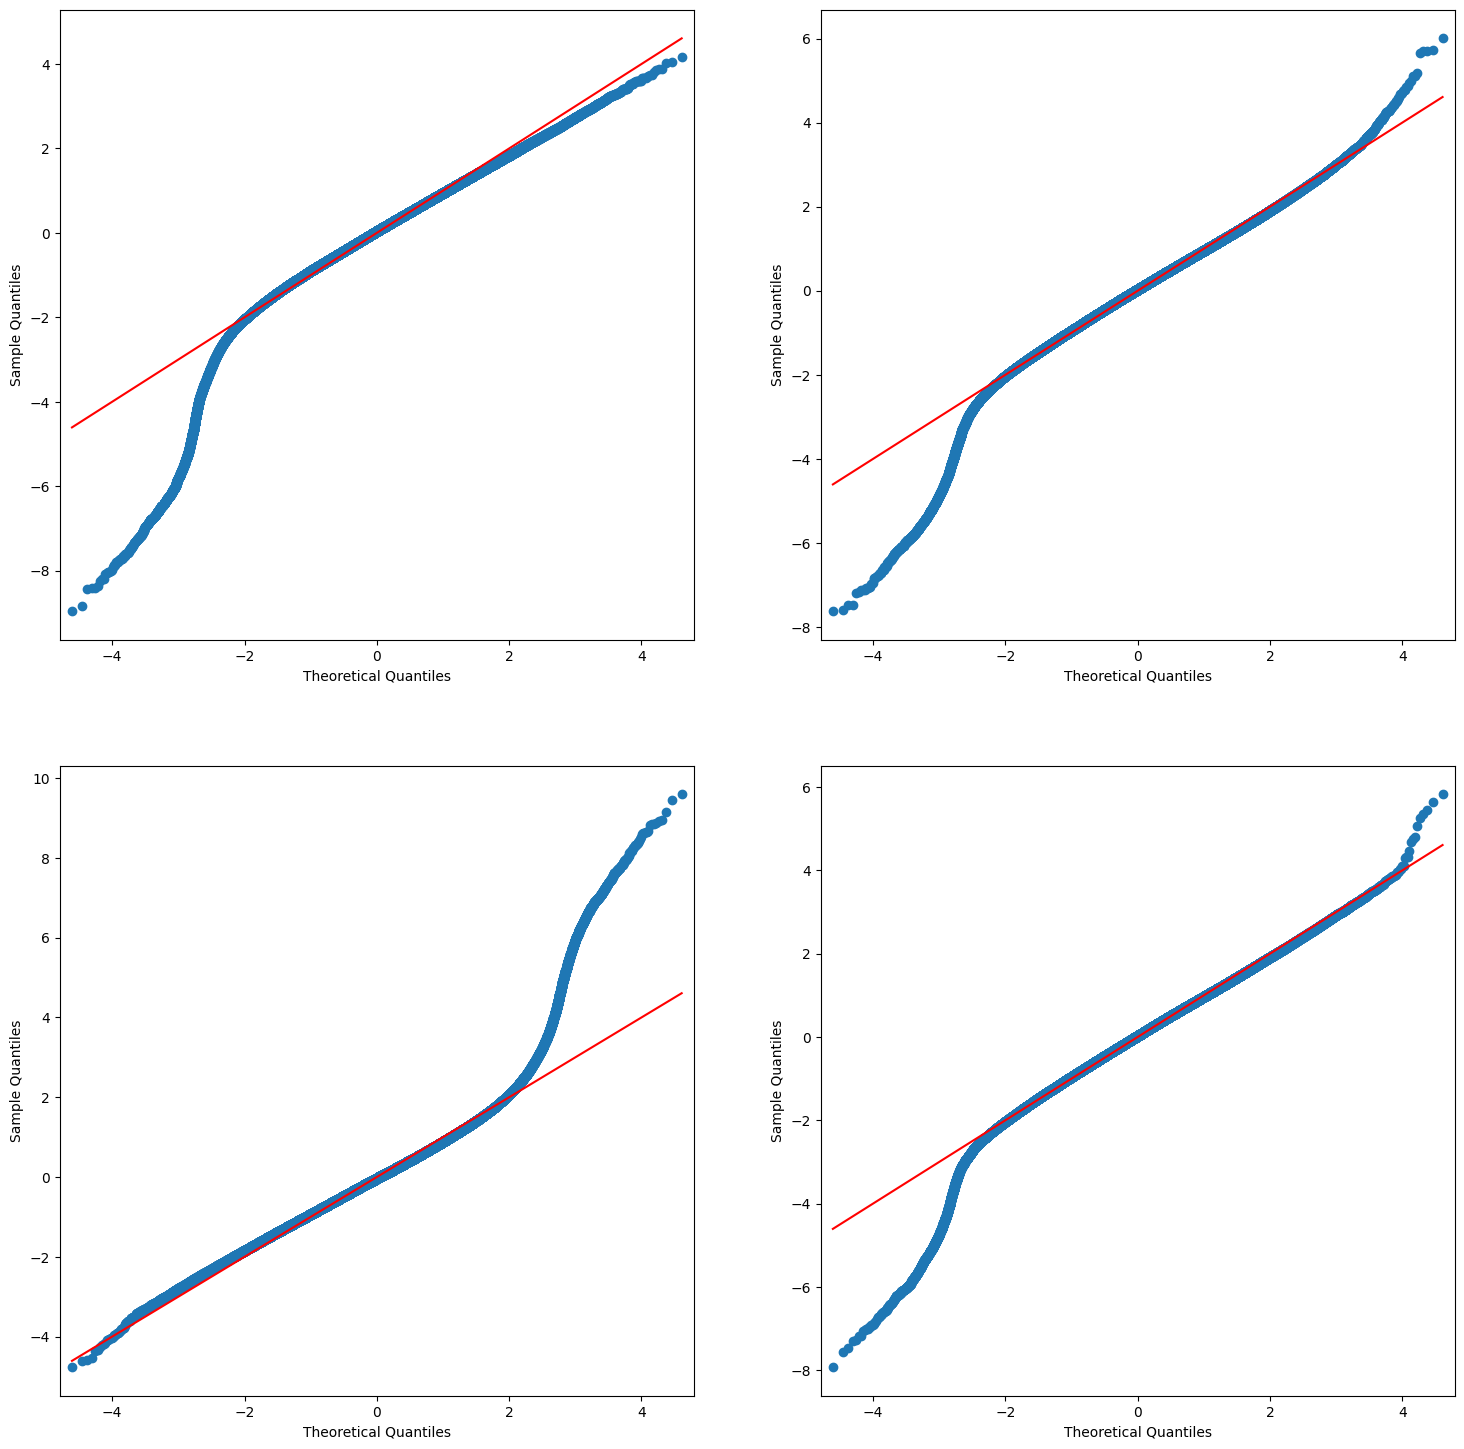

In [41]:
fig, axs = plt.subplots(2, 2,figsize=(18,18))
ax = axs.flatten()
feats = [8,16,32,64] #We explore a different set of features
for idx,a in enumerate(ax):
    qqplot(X_train.iloc[:,feats[idx]], line='s',ax=a)
plt.show()


We can test it more formally using hypothesis tests for gaussianity

In [42]:
from scipy.stats import shapiro

In [43]:
p_vals_shapiro = []
for i in range(2,max_feats):
    stat, p = shapiro(X_train.iloc[:,i])
    p_vals_shapiro.append(p)
#sum(np.array(p_vals_shapiro)>=0.05)
sum(np.array(p_vals_shapiro)>=1)

1

In [44]:
sum(np.array(p_vals_shapiro)>=0.05)

2

3 features are clearly gaussian with a p-value of 1, indicating that the shappiro test reports certainty of gaussianity even in the presente of millions of samples for a univariate test, only one more feature is added to this set if significance value is relaxed to 0.05

In [45]:
from scipy.stats import normaltest
p_vals_DAgostinok2 = [] 
for i in range(2,max_feats):
    stat, p = normaltest(X_train.iloc[:,i])
    p_vals_DAgostinok2.append(p)
sum(np.array(p_vals_DAgostinok2)>=0.05)

1

Interestingly no features pass the gaussianity test this time...

In [46]:
from scipy.stats import anderson
p_vals_anderson = [] 
for i in range(2,max_feats):
    result = anderson(X_train.iloc[:,i],dist='norm')
    fail = False
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic >= result.critical_values[i]:
            p_vals_anderson.append(0)
            fail = True
            break
    if not fail:
        p_vals_anderson.append(1)
sum(np.array(p_vals_anderson)>=0.05)

0

And according to this test, none

Our gaussianity  and previous trend analyses are likely just covering a design choice in the transformation of the variables, prior to the presentation of this data to the competition. This makes our data more amenable to certain modelling choices, and does not neccesarily affect the interrelations between values of different features (not to a point where our models are prevented from finding good solutions due to this change). Expanding on the usefulness of these discoveries is left as an extended exercise for the competitor.

Common visualization tools in time series analysis are the autocorrelation and partial autocorrelation plots. The rationale for its use resides in potentially leveraging the effect that previous
values may introduce in future values. However, in our case, this is not directly applicable as we are not given a time series. Something like adding features that are lagged values to our table will not work for this purpose. It is interesting, however, to consider summary statistics applied to the data at each date, and build a table that reflects exclusively information about the universe at a given date. For example and as a very simple formulation, one could compute the mean value of each feature at a given date, and build a new table that contains those values for a single date. This table is therefore comprised of as many rows as different dates are available in our data, and it is now directly compatible with a time series framework, where lagged effects can be used directly. 


In [47]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In our case, we will build a table on the standard deviation, and check the autocorrelation

In [48]:
#df_global = X_train.groupby('date').mean()
df_global = X_train.groupby('date').std()

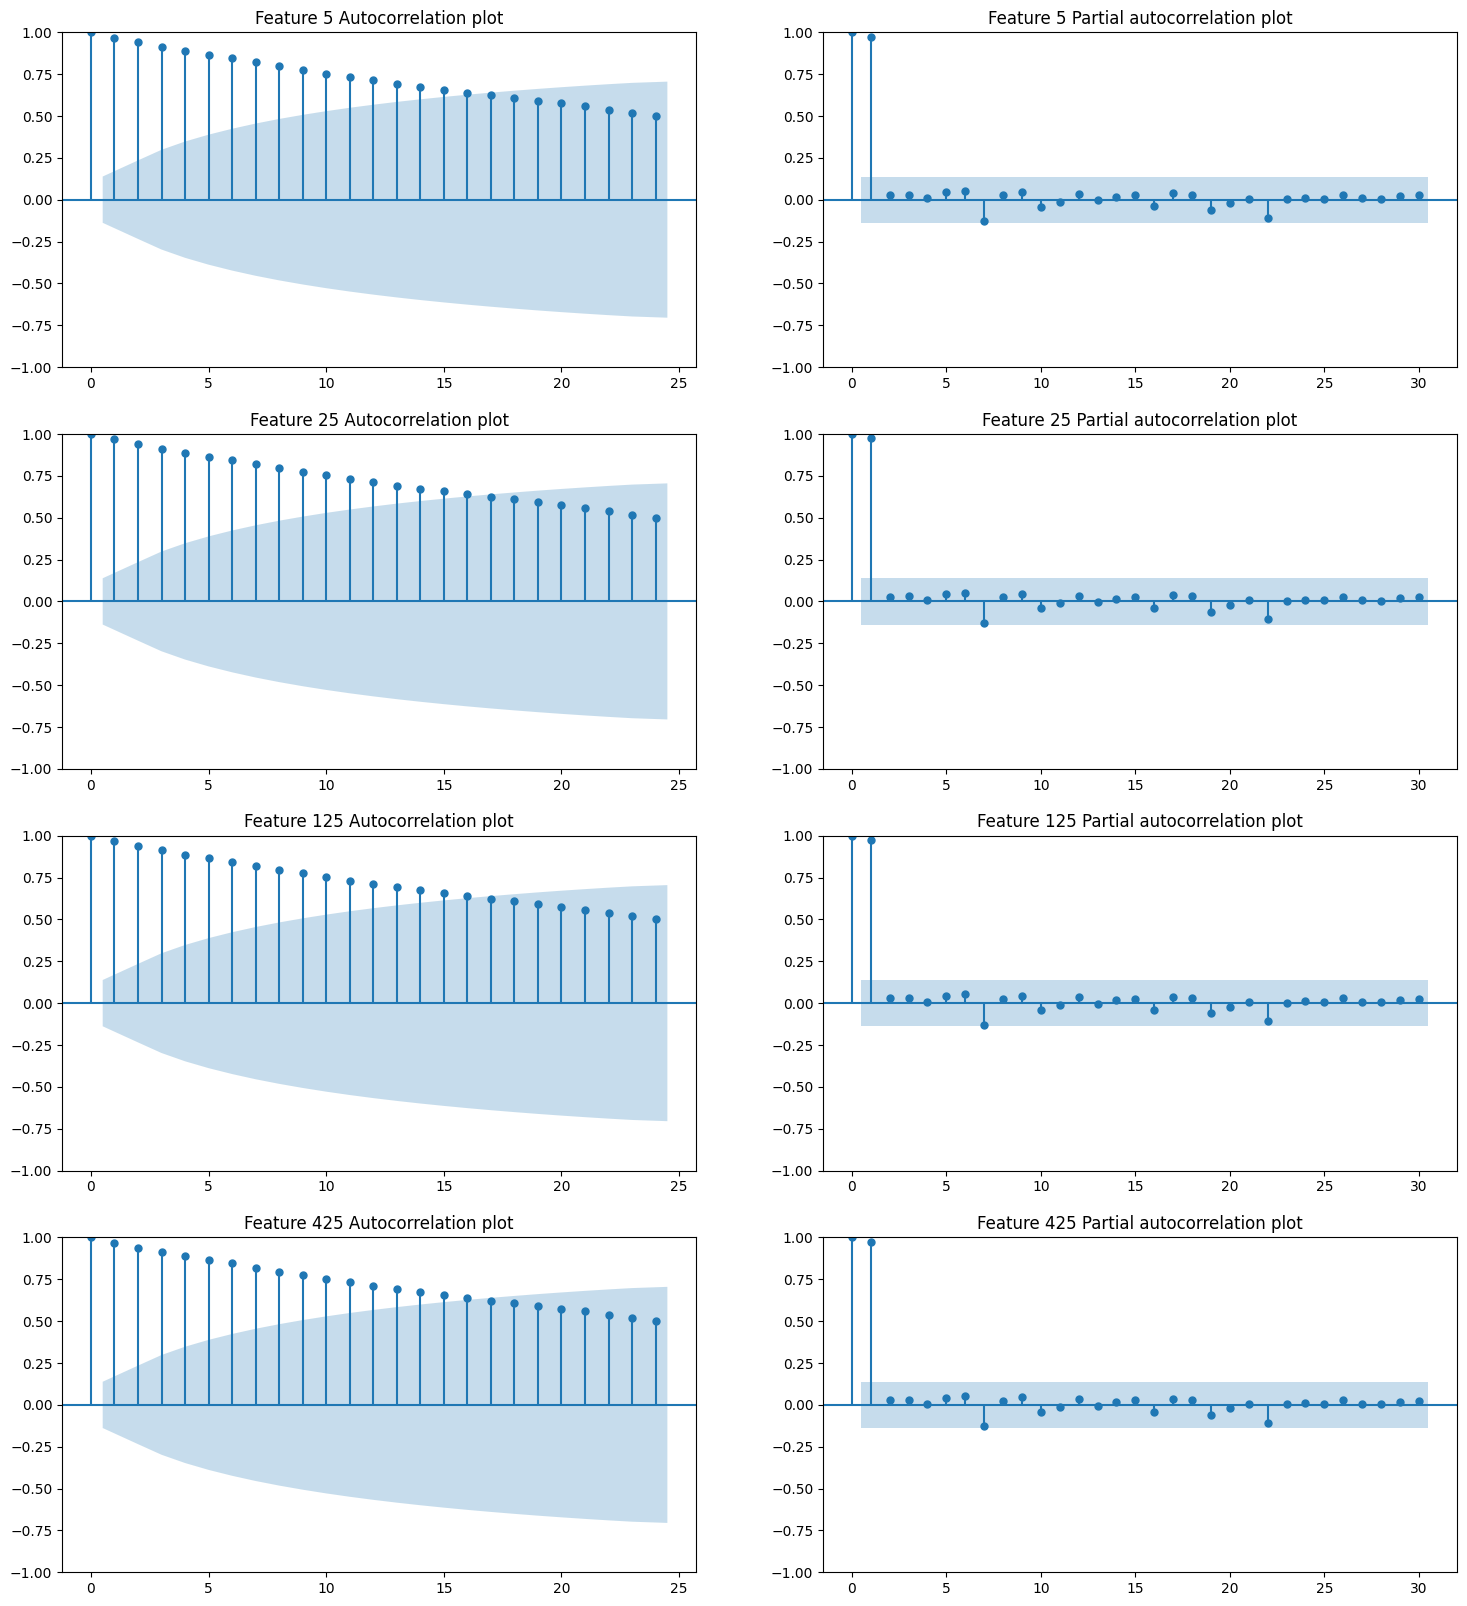

In [49]:
fig, axs = plt.subplots(4,2,figsize=(18,20))
ax = axs.flatten()
feats = ['5','25','125','425']
for i in range(4):
    a1 = ax[2*i]
    a2 =  ax[2*i+1]
    plot_acf(df_global[feats[i]],ax=a1)
    plot_pacf(df_global[feats[i]], lags=30,ax=a2) 
    a1.set_title('Feature ' +  feats[i] + ' Autocorrelation plot')
    a2.set_title('Feature ' +  feats[i] + ' Partial autocorrelation plot')
plt.show()

In all explored cases, results indicate the potential detection of linear effects at 1 lag in the partial autocorrelation plot, and what appears to be the same effect dissipating through increasing lags in the autocorrelation plot.  

In order to incorporate this data into a final submission, what needs to be done with the target variable, and what use would this data have are interesting and neccesary follow-up questions. This idea is mentioned up to this point but not explored in more detail in this notebook. It can be left as an exercise to the competitor and a possible direction to a final submission. We will however show, for the purposes of this discussion, the result of the autocorrelation and partial autocorrelation plots rawly applied to one feature of this data. 

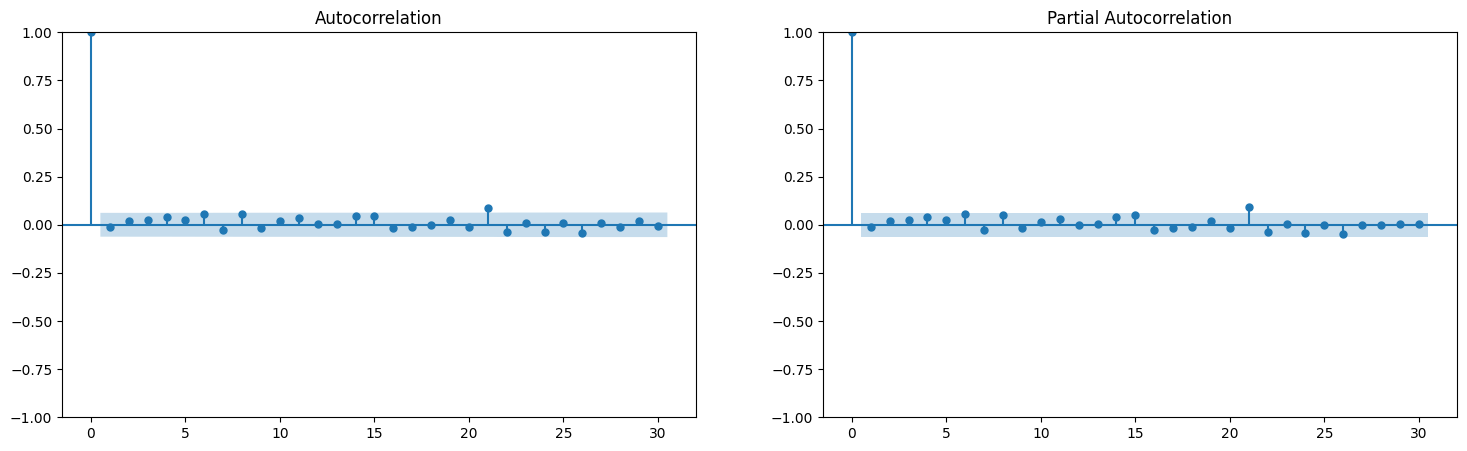

In [50]:
fig, axs = plt.subplots(1,2,figsize=(18,5))
ax = axs.flatten()
plot_acf(X_train.iloc[0:1000,3],ax=ax[0])
plot_pacf(X_train.iloc[0:1000,3],lags=30,ax=ax[1])
plt.show()

Results indicate no effects, and are consistent across all other features for which we have performed the test, as expected.

### Feature engineering

Our approach in this notebook will be centered around providing each row with information about the universe at the same date and the position of the sample within that universe. 
This will potentially enable our models to interpret the values obtained in the original features with respect to the values of the universe at that date (and how they relate to the final ranking).

Our objective is therefore to capture group-emergent properties that hopefully contain predictive power for our purposes.

We will add the following features:
1. **Centroid_distance**: We will compute the center point of the whole group (the mean of each feature separatedly conforms the centroid coordinate) and then obtain some l_p metric values, between the center and the sample at each row, for different values of l, namely 1, 2 and infinity. The hope is to capture any predictive power that the position of a sample, relative to all others in the "cloud of points" that conforms each date, offers. This will create the final features  **centroid_l1, centroid_l2** and **centroid_linf**.
4. **Sum_ranks**: For each feature, compute its ranking from lowest to highest in the whole group, per date, sum all the newly computed rankings
5. **Sum_values**: For each point, sum all the original values

Let us begin by dropping the id feature

In [51]:
X_train = X_train.drop('id',axis=1)
y_train = y_train.drop('id',axis=1)
max_feats-=1

And now introduce a method that directly adds the aforementioned features to our dataset. 

In [52]:
def calc_dist(l_norm,p1,p2): #A simple but general l_p distance method between 2 points of arbitraty dimension
    if l_norm == 0: #In here we use 0 to represent inf
        return np.max(np.abs(np.array(p1) - np.array(p2)))
    else:
        return np.float_power(sum(np.abs(np.power(np.array(p1) - np.array(p2),l_norm))),1/l_norm)

def compute_features_of_interest_local(data): #This is per date, will be called once per existing date
    n,d = data.shape        
    feats = list(data.columns)[1:]    
    centroid = []
    sds = []
    data.loc[:,'sum_rank'] = 0
    data.loc[:,'sum_vals'] = 0
    for feat in feats:
        df = data[feat]
        dfs = np.array(sorted(enumerate(df),key= lambda x: x[1],reverse=True))[:,0] #rankings of each feature w.r.t the others (low rank higher score) 
        data.loc[:,'sum_rank'] = dfs + data.loc[:,'sum_rank']     
        centroid.append(df.mean())
    data.loc[:,'centroid_l2'] = data.loc[:,feats].apply(lambda x: calc_dist(2,centroid,x),axis=1)
    data.loc[:,'centroid_l1'] = data.loc[:,feats].apply(lambda x: calc_dist(1,centroid,x),axis=1)
    data.loc[:,'centroid_linf'] = data.loc[:,feats].apply(lambda x: calc_dist(0,centroid,x),axis=1)
    data.loc[:,'sum_vals'] = data.apply(lambda x: sum(x[1:max_feats]),axis=1) #We quickly can add another feature to summarize the overall ranking
    return data

Notice that our previous method needs to be called for each date in order to produce the relative rankings correctly, as well as the other features, we follow up with this

In [53]:
X_train_ex = [] #Saves the result of the expanded data at every date
for date in tqdm(range(max_date+1)):
    X_train_ex.append(compute_features_of_interest_local(X_train.loc[X_train['date']==date,:]))

100%|██████████| 201/201 [04:28<00:00,  1.34s/it]


...and merge the results into a processed dataset

In [54]:
X_train_2 = pd.concat(X_train_ex) 

In [55]:
import snappy
import fastparquet

X_train_2.to_parquet('X_train_2.snap.parquet',compression='snappy')# After a lenghtly feature computation, We will save our data at this point

ModuleNotFoundError: No module named 'snappy'

In [ ]:
X_train_2.memory_usage().sum()/1024**2 #It occupies roughly 1.5Gb in this form

1576.8224487304688

In [ ]:
X_train_2 = pd.read_parquet('X_train_2.snap.parquet')
y_train = pd.read_parquet('y_train.parquet',engine='pyarrow')

In [ ]:
X_train_2

,date,0,1,2,3,4,5,6,7,8,...,456,457,458,459,460,sum_rank,sum_vals,centroid_l2,centroid_l1,centroid_linf
0,0,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,1.284785,...,-0.538754,-0.625193,-0.753419,0.154403,1.069385,173372.0,2.267677,16.526069,286.223343,2.655033
1,0,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,-0.593661,...,1.612578,0.302153,-0.165713,0.905807,0.083180,191368.0,6.025991,14.908755,256.888173,1.995446
2,0,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,0.031204,...,1.255969,0.270394,1.272939,-0.643112,0.433585,192196.0,38.329151,15.820451,272.008133,2.681078
3,0,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,1.613204,...,-0.322965,0.999248,-1.238640,0.882844,-1.333590,188273.0,12.965773,31.506768,561.033847,4.119639
4,0,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,-0.820445,...,0.674665,-1.095657,-0.402669,0.677189,0.319992,190881.0,-5.214201,16.349947,277.354187,2.568317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872051,299,0.046408,-0.458314,-1.264059,0.751480,-0.496721,-0.782261,-0.389080,-0.563787,-0.346818,...,-0.156987,0.949862,0.752885,1.081212,0.520880,898601.0,17.200779,20.280064,344.656224,3.060765
872052,299,-0.987864,-1.018630,-1.134292,2.111356,-0.516374,-0.198890,-0.380694,-0.055733,1.412662,...,-0.413168,0.604046,0.548162,-1.636762,0.286340,874961.0,33.935674,19.254229,338.879202,2.563466
872053,299,-0.993201,0.870104,-0.374045,-1.829752,1.194346,0.341354,-2.527532,1.675634,0.265051,...,2.049471,-2.990494,0.871132,-0.497221,-0.974846,825314.0,61.969277,31.150268,534.200771,4.446065
872054,299,-1.154332,0.507522,-0.123094,-0.487880,0.459085,-1.368539,-0.273953,-0.189072,-0.427886,...,0.430112,1.472343,0.678710,0.424044,-0.878932,898133.0,-14.599679,18.833607,323.398942,2.857851


### Modelization 

We will move our efforts now towards modelization, in this notebook, we will consider 2 approaches:
1. Plain regression on the whole dataset
2. Plan regression on a windowed dataset

Let us proceed with both. 


We start by choosing our validation scheme. We will use temporal cross validation to test the generalization capabilities of our models.






In [ ]:
from sklearn.model_selection import TimeSeriesSplit

As we have discussed, our dataset is not conventionally arranged as a time series, since we have multiple measures per date, and the feature "date" acts as our "clock", rather than a prespecified order that sorts samples in time. If we were to divide the dataset in contiguous chunks of data, we would be mixing data from different dates. This is undesirable for our purposes and thus, in order to construct a proper temporal cross validation, the splits need to occur on different dates.

We should also concern ourselves with the target loss of our problem (IC or Spearman's rank correlation). All of it will be implemented below

In [ ]:
def TemporalCV(List_models,X_data,y_data,n_splits=5,max_train_size=None,test_size=None):
    X = np.array(list(range(max_date))) #Now this is dates, which is where we make the splits, instead of using rows directly
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size= max_train_size,test_size=test_size) 
    stats_CV = {} #Storage of performance 
    count = 0
    for train, test in tscv.split(X):
        fold_train_X = X_data.loc[np.logical_and(X_data['date'] >= train[0],X_data['date'] <= train[-3]),:]
        fold_train_y = y_data.loc[np.logical_and(y_data['date'] >= train[0], y_data['date'] <= train[-3]),:]

        fold_test_X = X_data.loc[np.logical_and(X_data['date'] >= test[0], X_data['date'] <= test[-1]),:]
        fold_test_y = y_data.loc[np.logical_and(y_data['date'] >= test[0], y_data['date'] <= test[-1]),:]
        count+=1
        sample_pred = fold_test_y.copy()
        for model in List_models:
            model_name = model.__class__.__name__            
            model.fit(fold_train_X,fold_train_y.loc[:,['y']])  
            preds = model.predict(fold_test_X)
            sample_pred.loc[:,'y'] = preds.astype(float) 
            score = get_rank_corr_score(sample_pred,fold_test_y)            
            if model_name in stats_CV:
                stats_CV[model_name].append(score)
            else:
                stats_CV[model_name] = [score]
    return stats_CV

def get_rank_corr_score(y_preds,y_trues):
    rank_pred = y_preds.groupby('date',group_keys=True).apply(lambda x: x.rank(pct=True, method="first"))    
    correlation_score = np.corrcoef(rank_pred['y'],y_trues['y'])[0,1]
    return correlation_score

For our choice of models, previous analysis seem to paint a good picture with regards to the use of linear models (high volatility, weakly correlated features). We will test
their performance under different Temporal CV arrangements

In [ ]:
import sklearn.linear_model

In [ ]:
List_models = [
    sklearn.linear_model.LinearRegression(),
    sklearn.linear_model.Lasso(alpha=0.001),
    sklearn.linear_model.ElasticNet(alpha=0.6,l1_ratio=0.001),    
    sklearn.linear_model.Ridge(alpha=0.6) 
] 

Our LinearRegression model obtained an average score of 0.04052586592020783 in our CV scheme, with a standard deviation of 0.009690609649151001
Our Lasso model obtained an average score of 0.04197417194145229 in our CV scheme, with a standard deviation of 0.009408733828514352
Our ElasticNet model obtained an average score of 0.04207240622100506 in our CV scheme, with a standard deviation of 0.009900014871332678
Our Ridge model obtained an average score of 0.040540109824532454 in our CV scheme, with a standard deviation of 0.009678935707447885


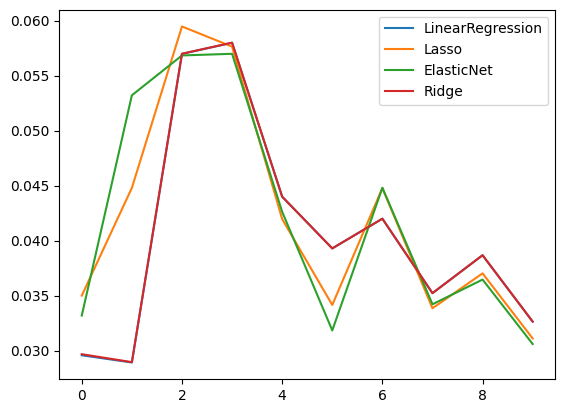

In [ ]:
statsCV = TemporalCV(List_models=List_models,X_data=X_train_2, y_data = y_train,n_splits=10)
for key, item in statsCV.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV.keys())

In this setting, ElasticNet emerged as a winner with a performance slightly above the other models. Parameters for Ridge, Lasso and ElasticNet were chosen after a small hyperparameter search were we attempted different values and obtained the temporal CV performance for each model. Besides the ranking of the models, it can also be noticed that the last evaluations have a tendency towards worse performance. This, in a expanding window, corresponds to the cases where the highest amount of training data was used, which additionally motivates the subsequent study, where performance using a sliding window is evaluated.



But first, let us now quickly assess if our feature engineering efforts had any effect on the overall score

Our LinearRegression model obtained an average score of 0.04046023045005267 in our CV scheme, with a standard deviation of 0.00990670007068372
Our Lasso model obtained an average score of 0.041781562022292815 in our CV scheme, with a standard deviation of 0.010028490655152041
Our ElasticNet model obtained an average score of 0.041935704019953154 in our CV scheme, with a standard deviation of 0.010368116634473581
Our Ridge model obtained an average score of 0.040472209232122455 in our CV scheme, with a standard deviation of 0.009896862765649776


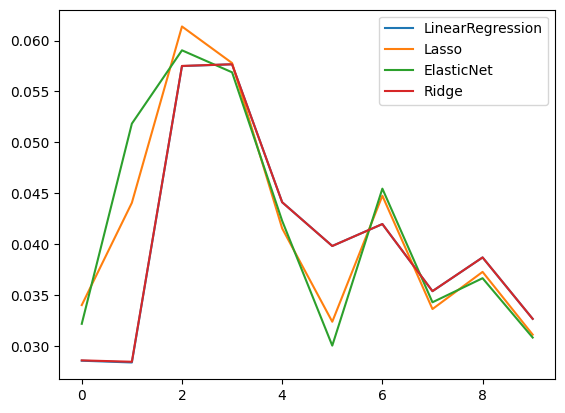

In [ ]:
statsCV0 = TemporalCV(List_models=List_models,X_data=X_train_2.iloc[:,0:max_feats], y_data = y_train,n_splits=10)
for key, item in statsCV0.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV0.keys())   

Our features seem to increase the linear models ability to predict rankings correctly by a tiny bit. Let us now explore what happens if we include only our engineered features and
regress on that

Our LinearRegression model obtained an average score of 0.012446836330867028 in our CV scheme, with a standard deviation of 0.007168029332335979
Our Lasso model obtained an average score of 0.012256175300702749 in our CV scheme, with a standard deviation of 0.007122394975784172
Our ElasticNet model obtained an average score of 0.012200838775660318 in our CV scheme, with a standard deviation of 0.007212257971662278
Our Ridge model obtained an average score of 0.012447055263111158 in our CV scheme, with a standard deviation of 0.007168594896889715


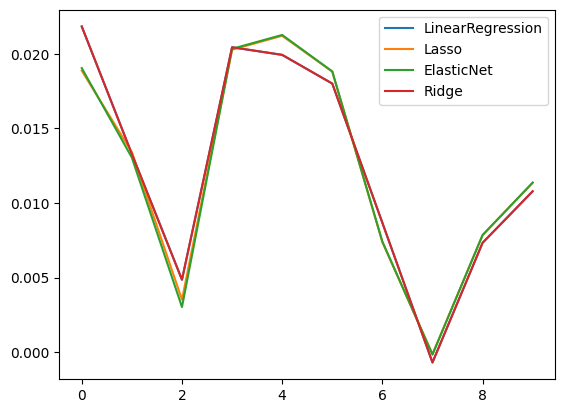

In [ ]:
statsCV1 = TemporalCV(List_models=List_models,X_data=X_train_2.drop(X_train_2.columns[1:max_feats],axis=1), y_data = y_train,n_splits=10)
for key, item in statsCV1.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV1.keys()) 

It seems that predictions have consistently become much worse without the original features, yet this results may suggest that the newly added features capture some of the target signal. Also interestingly, it seems like the Linear regression model is now outperforming all others.

Let us now consider a sliding window approach, we perform the validation while training on a window of 10 dates. If enough information about the state of the problem is contained in just few previous steps, and if information from distant past did not contribute to current prediction due to drift, then this approach would be positively rewarded with respect to the previous one. Suscribing to the notion that distant past observations may be harmful for future predictions should translate, if we choose to proceed this way, into bounding both the training and test sizes (or at least in the awareness of potential performance losses in big test sizes). The reason is that if such property were to be true, then for distant future predictions, our training data will be considered distant past, and therefore already assumed to be subpar. We will see what happens

Our LinearRegression model obtained an average score of 0.012188868352513206 in our CV scheme, with a standard deviation of 0.017732048186730607
Our Lasso model obtained an average score of 0.014472960879564548 in our CV scheme, with a standard deviation of 0.02165503845287582
Our ElasticNet model obtained an average score of 0.01403855741863802 in our CV scheme, with a standard deviation of 0.02409514122575251
Our Ridge model obtained an average score of 0.01245962678208777 in our CV scheme, with a standard deviation of 0.01834881470725991


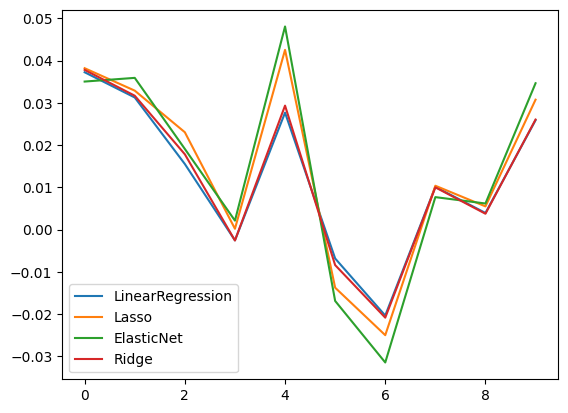

In [ ]:
statsCV2 = TemporalCV(List_models=List_models,X_data=X_train_2, y_data = y_train,n_splits=10,max_train_size=10,test_size=10)
for key, item in statsCV2.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV2.keys())

Clearly, performance seems to have suffered a drop in all cases. 
In order to increase our understanding of the situation, let us conduct experiments with different values

Our LinearRegression model obtained an average score of 0.024428086591299497 in our CV scheme, with a standard deviation of 0.011858963757718883
Our Lasso model obtained an average score of 0.030534206616489055 in our CV scheme, with a standard deviation of 0.011922859114866924
Our ElasticNet model obtained an average score of 0.030918147225914665 in our CV scheme, with a standard deviation of 0.012399386764010315
Our Ridge model obtained an average score of 0.024749927494124392 in our CV scheme, with a standard deviation of 0.011816424399620249


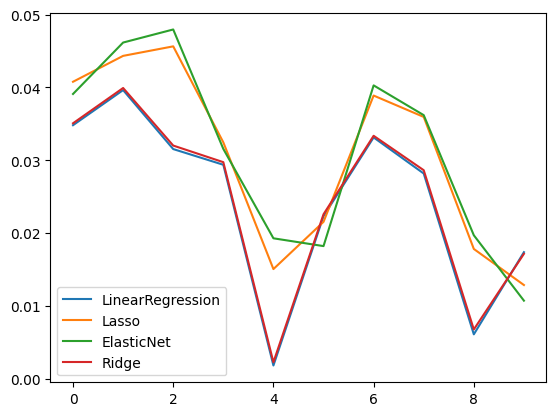

In [ ]:
statsCV3 = TemporalCV(List_models=List_models,n_splits=10,X_data=X_train_2, y_data = y_train,max_train_size=20,test_size=20)
for key, item in statsCV3.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV3.keys()) 


Our LinearRegression model obtained an average score of 0.022599824611990893 in our CV scheme, with a standard deviation of 0.012359597453119358
Our Lasso model obtained an average score of 0.02758143655745534 in our CV scheme, with a standard deviation of 0.01646945497412944
Our ElasticNet model obtained an average score of 0.027356344977040953 in our CV scheme, with a standard deviation of 0.016519484899435007
Our Ridge model obtained an average score of 0.02290662405055902 in our CV scheme, with a standard deviation of 0.012449239522969297


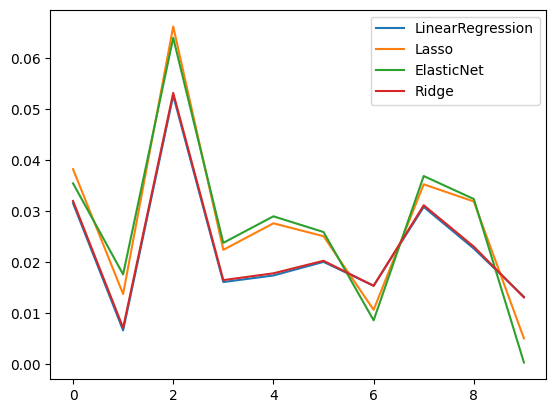

In [ ]:
statsCV4 = TemporalCV(List_models=List_models,X_data=X_train_2, y_data = y_train,n_splits=10,max_train_size=20)
for key, item in statsCV4.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV4.keys()) 

Our LinearRegression model obtained an average score of 0.035787865417487325 in our CV scheme, with a standard deviation of 0.01049373294547055
Our Lasso model obtained an average score of 0.03638178692272099 in our CV scheme, with a standard deviation of 0.013385741860828835
Our ElasticNet model obtained an average score of 0.03586177107887502 in our CV scheme, with a standard deviation of 0.013962530137328564
Our Ridge model obtained an average score of 0.03580483690684921 in our CV scheme, with a standard deviation of 0.010500591169559178


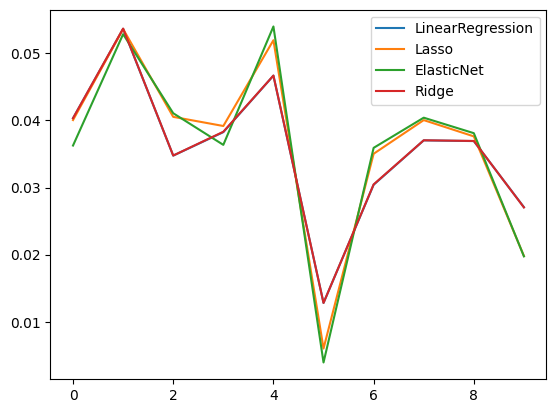

In [ ]:
statsCV5 = TemporalCV(List_models=List_models,X_data=X_train_2, y_data = y_train,n_splits=10,max_train_size=60,test_size=20)
for key, item in statsCV5.items():
    plt.plot(item)
    print('Our ' + key + ' model obtained an average score of ' + str(np.mean(item)) + ' in our CV scheme, with a standard deviation of ' + str(np.std(item)))
plt.legend(statsCV5.keys()) 


Conclusion on linear models so far:

1. Bounding the sample size seems to clearly decrease performance. Our expanding window approach was the clear winner of our experiments
2. Results have been quite good for Lasso and ElasticNet regression, consistently outperforming all other linear alternatives
3. Our crafted features had a small positive effect in the average score



From this point forward, what is left is to select our final model and hyperparameters and call the API to produce our final submission on unseen data. See ADIA forecast API [[URL here]] for a guide on this part.

### Future work/Alternative ideas

Here are some ideas to expand on the work presented in this notebook
1. Global universe dataset: As shown earlier, we can obtain a version of our data that does conform to a time series framework. With sufficiently detailed statistics, it would be possible to
obtain predictions about the properties of the next iteration of our universe. This predictions, made by models operating at a lower granularity than our data, could be combined in the form
of constrains, neutralizations or conditions so that our predictions on the original target are fine tuned
2. Ranking ML: One could sidestep the problem of predicting the target directly by attempting to rank the points directly. Techniques such as RankNet, LambdaRank or LambdaMART could be explored in the context of this problem 
3. Differential features: A whole array of features can be created that require information from previous dates to be constructed. This can equip our final dataset with information from previous steps without neccesarily using the lag functionality. These could include: The prediction of models trained on previous dates of the samples in current date, distance to the centroid point of the data in past dates to points in current date, ranking of points in current date among the samples of previous dates, closest neighbors of samples of current date to samples in past dates...etc
4. Feature subset selection: Our dataset has a considerable number of features, feature importance analysis and feature prunning techniques may result in improvements in performance
5. Additional Feature engineering: Our approach depicts only a fraction of possible additional features that can be defined for this problem. Additional features could include effects such as rolling windows(from which averages, medians and ranges of values can be extracted) of values for different dates, or be of a completely different nature
6. Additional data exploration: Our data explorations efforts were kept to a length compatible with a tutorial/introductory/boostraping notebook, most likely much finer detail and insight is still awaiting within the data
7. Additional data preprocessing techniques: outliers detection to de-bias predictions, clustering in feature space...etc
8. Fine-tune the loss function: Models in this notebook were trained to minimize MSE. Alterantives that better align with our scoring metric should be explored as well